# Part III – LLM Dialogue-Act Annotation with Qwen (Ollama)

This notebook:
- Loads my mini-corpus of utterances.
- Uses a local LLM (Qwen via Ollama) to annotate dialogue acts.
- Performs iterative prompt refinement (multiple prompt versions).
- Annotates the full dataset with the best prompt.
- Computes inter-annotator agreement (Cohen's κ) between humans and the LLM.

**Note:** This template assumes you have Ollama installed and a `qwen` model available.
You may need to adjust file paths and model names to match your setup.

In [1]:
import pandas as pd
import json
import ollama
from sklearn.metrics import cohen_kappa_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

pd.set_option('display.max_colwidth', 200)


## 1. Load data

This cell loads the utterances exported from ELAN.

It assumes the file is a tab-delimited text file with the following columns:

1. tier speaker name
2. participant name
3. start time (string)
4. start time (seconds)
5. end time (string)
6. end time (seconds)
7. duration (string)
8. duration (seconds)
9. utterance text

If you later add human annotation labels (e.g. `human1_label`, `human2_label`), you can
merge them into this DataFrame or load a different file.

In [2]:
utter_path = 'shared_memory_transcript_updated.txt'

df = pd.read_csv(
    utter_path,
    sep='\t',
    header=None,
    names=['tier_speaker', 'speaker', 'start_str', 'start_sec', 'end_str', 'end_sec', 'dur_str', 'dur_sec', 'utterance'],
    engine='python'
)

print(df.head())
print('Total utterances:', len(df))

  tier_speaker speaker     start_str  start_sec       end_str  end_sec  \
0        Manar   Manar  00:01:05.149     65.149  00:01:09.920   69.920   
1        Manar   Manar  00:01:11.620     71.620  00:01:12.083   72.083   
2        Manar   Manar  00:01:15.412     75.412  00:01:16.640   76.640   
3        Manar   Manar  00:01:18.100     78.100  00:01:20.040   80.040   
4        Manar   Manar  00:01:21.726     81.726  00:01:22.527   82.527   

        dur_str  dur_sec  \
0  00:00:04.771    4.771   
1  00:00:00.463    0.463   
2  00:00:01.228    1.228   
3  00:00:01.940    1.940   
4  00:00:00.801    0.801   

                                                                        utterance  
0  Yeah man you(.) do you remember like that day we traveled also(.) to: germany.  
1                                                                           yeah.  
2                                                             =I think more! Man.  
3                                       Two and ha

### Optional: Add human label columns

If you already have human annotations in a separate file, you can merge them here.
For now, we create placeholder columns `human1_label` and `human2_label` that you can
fill externally (e.g. in Excel) and re-load later.

In [3]:
if 'human1_label' not in df.columns:
    df['human1_label'] = pd.NA
if 'human2_label' not in df.columns:
    df['human2_label'] = pd.NA

df.head()

,tier_speaker,speaker,start_str,start_sec,end_str,end_sec,dur_str,dur_sec,utterance,human1_label,human2_label
0,Manar,Manar,00:01:05.149,65.149,00:01:09.920,69.920,00:00:04.771,4.771,Yeah man you(.) do you remember like that day we traveled also(.) to: germany.,<NA>,<NA>
1,Manar,Manar,00:01:11.620,71.620,00:01:12.083,72.083,00:00:00.463,0.463,yeah.,<NA>,<NA>
2,Manar,Manar,00:01:15.412,75.412,00:01:16.640,76.640,00:00:01.228,1.228,=I think more! Man.,<NA>,<NA>
3,Manar,Manar,00:01:18.100,78.100,00:01:20.040,80.040,00:00:01.940,1.940,"Two and halve years, something like that.",<NA>,<NA>
4,Manar,Manar,00:01:21.726,81.726,00:01:22.527,82.527,00:00:00.801,0.801,=Maybe.,<NA>,<NA>


## 2. Define dialogue-act labels

These are the labels we will use for annotation, based on your scheme.

In [27]:
DA_LABELS = [
    'STATEMENT',
    'QUESTION',
    'ANSWER',
    'ACKNOWLEDGEMENT',
    'BACKCHANNEL',
    'DIRECTIVE',
    'REQUEST',
    'REPAIR',
    'CLARIFICATION',
    'EXPRESSIVE',
    'EMOTIVE',
    'APOLOGY',
    'GREETING',
    'GOODBYE/CLOSING',
    'OTHER'
]
DA_LABELS

['STATEMENT',
 'QUESTION',
 'ANSWER',
 'ACKNOWLEDGEMENT',
 'BACKCHANNEL',
 'DIRECTIVE',
 'REQUEST',
 'REPAIR',
 'CLARIFICATION',
 'EXPRESSIVE',
 'EMOTIVE',
 'APOLOGY',
 'GREETING',
 'GOODBYE/CLOSING',
 'OTHER']

## 3. Helper: call Qwen via Ollama

This function sends a batch of utterances to the model with a given prompt and expects
JSON output of the form:

```json
[{"index": 1, "label": "STATEMENT"}, ...]
```

In [28]:
def annotate_batch_with_llm(utterances, prompt, temperature=0.3, model_name='qwen3:0.6b'):
    joined = '\n'.join([f"{i+1}. {u}" for i, u in enumerate(utterances)])

    full_prompt = f"""{prompt}

Here are the utterances to annotate:
{joined}

Return ONLY valid JSON as a list of objects:
[
  {{"index": 1, "label": "STATEMENT"}},
  ...
]
"""

    response = ollama.chat(
        model=model_name,
        messages=[{'role': 'user', 'content': full_prompt}],
        options={'temperature': temperature}
    )

    text = response['message']['content'].strip()

    try:
        annotations = json.loads(text)
    except json.JSONDecodeError as e:
        print('Failed to parse JSON from model output:')
        print(text)
        raise e

    return annotations

## 4. Prompt Version 1 – initial instructions

This is the base prompt that defines your labels and how the model should respond.
You will refine it over several versions.

In [29]:
prompt_v1 = '''
You are annotating dialogue acts in a conversation.

Use EXACTLY ONE label per utterance, chosen from:
STATEMENT, QUESTION, ANSWER, ACKNOWLEDGEMENT, BACKCHANNEL,
DIRECTIVE, REQUEST, REPAIR, CLARIFICATION,
EXPRESSIVE, EMOTIVE, APOLOGY, GREETING,
GOODBYE/CLOSING, OTHER.

Definitions:
- STATEMENT: provides information, description, or opinion.
- QUESTION: requests information or clarification.
- ANSWER: directly responds to a question or confirmation request.
- ACKNOWLEDGEMENT/BACKCHANNEL: signals attention, understanding, or agreement
  without adding new content (e.g. "yeah", "mm-hmm", "right").
- DIRECTIVE/REQUEST: asks the other speaker to do something or to clarify something.
- REPAIR/CLARIFICATION: corrects or reformulates previous speech, or asks for clarification
  (e.g. "No, I meant last week", "Wait, who was there?").
- EXPRESSIVE/EMOTIVE: conveys emotional stance, evaluation, or affective reaction
  (e.g. "That was amazing!", "Ugh, I hated that part").
- APOLOGY: acknowledges fault or expresses regret.
- GREETING: opens the interaction or marks social connection.
- GOODBYE/CLOSING: signals the end of the interaction or closing the topic.
- OTHER: does not fit the categories above (e.g. laughter, filler noises, unintelligible speech).

Rules:
- Assign EXACTLY ONE label per utterance.
- Only use labels from the set given above.
- If unsure, choose the best fitting category and do NOT invent new labels.
'''
print(prompt_v1)


You are annotating dialogue acts in a conversation.

Use EXACTLY ONE label per utterance, chosen from:
STATEMENT, QUESTION, ANSWER, ACKNOWLEDGEMENT, BACKCHANNEL,
DIRECTIVE, REQUEST, REPAIR, CLARIFICATION,
EXPRESSIVE, EMOTIVE, APOLOGY, GREETING,
GOODBYE/CLOSING, OTHER.

Definitions:
- STATEMENT: provides information, description, or opinion.
- QUESTION: requests information or clarification.
- ANSWER: directly responds to a question or confirmation request.
- ACKNOWLEDGEMENT/BACKCHANNEL: signals attention, understanding, or agreement
  without adding new content (e.g. "yeah", "mm-hmm", "right").
- DIRECTIVE/REQUEST: asks the other speaker to do something or to clarify something.
- REPAIR/CLARIFICATION: corrects or reformulates previous speech, or asks for clarification
  (e.g. "No, I meant last week", "Wait, who was there?").
- EXPRESSIVE/EMOTIVE: conveys emotional stance, evaluation, or affective reaction
  (e.g. "That was amazing!", "Ugh, I hated that part").
- APOLOGY: acknowledges 

## 5. Test Prompt V1 on a small subset

We start with 10 utterances to see how well the model follows the instructions.

In [30]:
test_df = df.iloc[:10].copy()
test_utterances = test_df['utterance'].tolist()

annotations_v1 = annotate_batch_with_llm(
    utterances=test_utterances,
    prompt=prompt_v1,
    temperature=0.3,
    model_name='qwen3:0.6b'
)

annotations_v1

[{'index': 1, 'label': 'STATEMENT'},
 {'index': 2, 'label': 'ACKNOWLEDGEMENT'},
 {'index': 3, 'label': 'STATEMENT'},
 {'index': 4, 'label': 'STATEMENT'},
 {'index': 5, 'label': 'STATEMENT'},
 {'index': 6, 'label': 'STATEMENT'},
 {'index': 7, 'label': 'STATEMENT'},
 {'index': 8, 'label': 'QUESTION'},
 {'index': 9, 'label': 'STATEMENT'},
 {'index': 10, 'label': 'STATEMENT'}]

In [31]:
# Attach V1 annotations to the test DataFrame for inspection
idx_to_label_v1 = {ann['index']: ann['label'] for ann in annotations_v1}

test_df['llm_v1_label'] = [idx_to_label_v1[i+1] for i in range(len(test_df))]
test_df[['utterance', 'human1_label', 'human2_label', 'llm_v1_label']]

,utterance,human1_label,human2_label,llm_v1_label
0,Yeah man you(.) do you remember like that day we traveled also(.) to: germany.,<NA>,<NA>,STATEMENT
1,yeah.,<NA>,<NA>,ACKNOWLEDGEMENT
2,=I think more! Man.,<NA>,<NA>,STATEMENT
3,"Two and halve years, something like that.",<NA>,<NA>,STATEMENT
4,=Maybe.,<NA>,<NA>,STATEMENT
5,yeah true↓ ↓ true man.,<NA>,<NA>,STATEMENT
6,But we [did like so mcuh].,<NA>,<NA>,STATEMENT
7,What did you post=?,<NA>,<NA>,QUESTION
8,oh yea yea the[ vlog].,<NA>,<NA>,STATEMENT
9,=the vlog thing,<NA>,<NA>,STATEMENT


### Prompt Version 2



In [32]:
prompt_v2 = prompt_v1 + '''

Additional rules:
- If an utterance consists only of very short tokens like "yeah", "mm-hmm", "uh-huh", "right",
  and does not add new information, ALWAYS label it as ACKNOWLEDGEMENT or BACKCHANNEL.
- If an utterance clearly asks for information or ends with a question mark,
  label it as QUESTION, not STATEMENT.
'''
print(prompt_v2)


You are annotating dialogue acts in a conversation.

Use EXACTLY ONE label per utterance, chosen from:
STATEMENT, QUESTION, ANSWER, ACKNOWLEDGEMENT, BACKCHANNEL,
DIRECTIVE, REQUEST, REPAIR, CLARIFICATION,
EXPRESSIVE, EMOTIVE, APOLOGY, GREETING,
GOODBYE/CLOSING, OTHER.

Definitions:
- STATEMENT: provides information, description, or opinion.
- QUESTION: requests information or clarification.
- ANSWER: directly responds to a question or confirmation request.
- ACKNOWLEDGEMENT/BACKCHANNEL: signals attention, understanding, or agreement
  without adding new content (e.g. "yeah", "mm-hmm", "right").
- DIRECTIVE/REQUEST: asks the other speaker to do something or to clarify something.
- REPAIR/CLARIFICATION: corrects or reformulates previous speech, or asks for clarification
  (e.g. "No, I meant last week", "Wait, who was there?").
- EXPRESSIVE/EMOTIVE: conveys emotional stance, evaluation, or affective reaction
  (e.g. "That was amazing!", "Ugh, I hated that part").
- APOLOGY: acknowledges 

In [90]:
prompt_v3 = prompt_v2 + '''

 IMPORTANT RULES

- Label ALL utterances you are given.
- Number them sequentially starting at 1.
- Assign exactly ONE label per utterance.
- Do NOT skip or invent indices.
- Do NOT explain your reasoning.

 DISAMBIGUATION RULES

- If an utterance like “yeah true man” adds a stance or an evaluation, label it STATEMENT, not ACKNOWLEDGEMENT.
- If a question form asks someone to do something (“What did you post?”), label it DIRECTIVE, not QUESTION.
- If the utterance conveys emotion or evaluation (“It was nice feelings, I swear”), label it EXPRESSIVE, even if declarative.
- Short non-informative responses are ACKNOWLEDGEMENTS unless they introduce new content.
- If the utterance answers a question, label it ANSWER regardless of length.
'''
print(prompt_v3)


You are annotating dialogue acts in a conversation.

Use EXACTLY ONE label per utterance, chosen from:
STATEMENT, QUESTION, ANSWER, ACKNOWLEDGEMENT, BACKCHANNEL,
DIRECTIVE, REQUEST, REPAIR, CLARIFICATION,
EXPRESSIVE, EMOTIVE, APOLOGY, GREETING,
GOODBYE/CLOSING, OTHER.

Definitions:
- STATEMENT: provides information, description, or opinion.
- QUESTION: requests information or clarification.
- ANSWER: directly responds to a question or confirmation request.
- ACKNOWLEDGEMENT/BACKCHANNEL: signals attention, understanding, or agreement
  without adding new content (e.g. "yeah", "mm-hmm", "right").
- DIRECTIVE/REQUEST: asks the other speaker to do something or to clarify something.
- REPAIR/CLARIFICATION: corrects or reformulates previous speech, or asks for clarification
  (e.g. "No, I meant last week", "Wait, who was there?").
- EXPRESSIVE/EMOTIVE: conveys emotional stance, evaluation, or affective reaction
  (e.g. "That was amazing!", "Ugh, I hated that part").
- APOLOGY: acknowledges 

In [33]:
annotations_v2 = annotate_batch_with_llm(
    utterances=test_utterances,
    prompt=prompt_v2,
    temperature=0.2,
    model_name='qwen3:0.6b'
)

idx_to_label_v2 = {ann['index']: ann['label'] for ann in annotations_v2}
test_df['llm_v2_label'] = [idx_to_label_v2[i+1] for i in range(len(test_df))]

test_df[['utterance', 'human1_label', 'human2_label', 'llm_v1_label', 'llm_v2_label']]

,utterance,human1_label,human2_label,llm_v1_label,llm_v2_label
0,Yeah man you(.) do you remember like that day we traveled also(.) to: germany.,<NA>,<NA>,STATEMENT,QUESTION
1,yeah.,<NA>,<NA>,ACKNOWLEDGEMENT,ACKNOWLEDGEMENT
2,=I think more! Man.,<NA>,<NA>,STATEMENT,STATEMENT
3,"Two and halve years, something like that.",<NA>,<NA>,STATEMENT,STATEMENT
4,=Maybe.,<NA>,<NA>,STATEMENT,STATEMENT
5,yeah true↓ ↓ true man.,<NA>,<NA>,STATEMENT,REPAIR
6,But we [did like so mcuh].,<NA>,<NA>,STATEMENT,STATEMENT
7,What did you post=?,<NA>,<NA>,QUESTION,QUESTION
8,oh yea yea the[ vlog].,<NA>,<NA>,STATEMENT,STATEMENT
9,=the vlog thing,<NA>,<NA>,STATEMENT,STATEMENT


## 7. Choose a final prompt

After trying at least 5 prompt versions, assign your best-performing one to `final_prompt`.

In [91]:
final_prompt = prompt_v3  # replace with your best prompt, e.g., prompt_v5
print(final_prompt[:500])


You are annotating dialogue acts in a conversation.

Use EXACTLY ONE label per utterance, chosen from:
STATEMENT, QUESTION, ANSWER, ACKNOWLEDGEMENT, BACKCHANNEL,
DIRECTIVE, REQUEST, REPAIR, CLARIFICATION,
EXPRESSIVE, EMOTIVE, APOLOGY, GREETING,
GOODBYE/CLOSING, OTHER.

Definitions:
- STATEMENT: provides information, description, or opinion.
- QUESTION: requests information or clarification.
- ANSWER: directly responds to a question or confirmation request.
- ACKNOWLEDGEMENT/BACKCHANNEL: signals


## 8. Annotate the full dataset with the final prompt

This function runs the LLM over the entire dataset in batches and stores
the predicted label in a new column `llm_label`.

In [77]:
def annotate_full_df_with_llm(df, prompt, batch_size=20, temperature=0.2, model_name="qwen3:0.6b"):
    llm_labels = []
    n = len(df)

    for start in range(0, n, batch_size):
        end = min(start + batch_size, n)
        batch_utts = df["utterance"].iloc[start:end].tolist()

        annotations = annotate_batch_with_llm(
            utterances=batch_utts,
            prompt=prompt,
            temperature=temperature,
            model_name=model_name
        )

        # Debug: show if length or indices look suspicious
        if len(annotations) != len(batch_utts):
            print(f"⚠️ Warning: batch {start}-{end} has {len(annotations)} annotations for {len(batch_utts)} utterances")
            print("Annotations returned:", annotations)

        # Build a mapping index -> label (if index is present)
        idx_to_label = {}
        for ann in annotations:
            idx = ann.get("index")
            lab = ann.get("label")
            if idx is not None and lab is not None:
                idx_to_label[idx] = lab

        batch_labels = []
        for i in range(len(batch_utts)):
            idx = i + 1  # we asked the model to use 1-based indices
            if idx in idx_to_label:
                batch_labels.append(idx_to_label[idx])
            else:
                # Fallback: if model skipped this index, assign OTHER and warn
                print(f"⚠️ Missing label for utterance index {idx} in batch {start}-{end}, assigning OTHER")
                batch_labels.append("OTHER")

        llm_labels.extend(batch_labels)
        print(f"Annotated {end}/{n} utterances")

    return llm_labels


In [78]:
df["llm_label"] = annotate_full_df_with_llm(
    df=df,
    prompt=final_prompt,
    batch_size=20,
    temperature=0.2,
    model_name="qwen3:0.6b"
)


Annotated 20/96 utterances
Annotated 40/96 utterances
Annotated 60/96 utterances
Annotated 80/96 utterances
Annotated 96/96 utterances


## 9. Save LLM-annotated data

Save the DataFrame with the new `llm_label` column for later analysis.

In [79]:
out_path = 'AttarA2_with_llm_labels.csv'
df.to_csv(out_path, index=False)
print('Saved:', out_path)

Saved: AttarA2_with_llm_labels.csv


## 10. Compute Cohen's κ

This section computes agreement between:
- Human 1 vs Human 2
- Human 1 vs LLM
- Human 2 vs LLM

Make sure you have filled in `human1_label` and `human2_label` before running this.
If they are still empty, κ will not be meaningful.

In [80]:
import pandas as pd

raw_path = "AttarA2_with_human_annotation.txt"

df_raw = pd.read_csv(
    raw_path,
    sep="\t",
    header=None,
    names=[
        "tier",        # e.g. Manar, Raihan, Manar_label, DiscourseAct_Manar
        "speaker",     # Manar / Raihan
        "start_str",
        "start_sec",
        "end_str",
        "end_sec",
        "dur_str",
        "dur_sec",
        "text"         # utterance OR label, depending on tier
    ],
    engine="python"
)

df_raw.head(20)


,tier,speaker,start_str,start_sec,end_str,end_sec,dur_str,dur_sec,text
0,Manar,Manar,00:01:05.149,65.149,00:01:09.920,69.920,00:00:04.771,4.771,Yeah man you(.) do you remember like that day we traveled also(.) to: germany.
1,Manar,Manar,00:01:11.620,71.620,00:01:12.083,72.083,00:00:00.463,0.463,yeah.
2,Manar,Manar,00:01:15.412,75.412,00:01:16.640,76.640,00:00:01.228,1.228,=I think more! Man.
3,Manar,Manar,00:01:18.100,78.100,00:01:20.040,80.040,00:00:01.940,1.940,"Two and halve years, something like that."
4,Manar,Manar,00:01:21.726,81.726,00:01:22.527,82.527,00:00:00.801,0.801,=Maybe.
5,Manar,Manar,00:01:30.030,90.030,00:01:32.300,92.300,00:00:02.270,2.270,yeah true↓ ↓ true man.
6,Manar,Manar,00:01:32.675,92.675,00:01:34.523,94.523,00:00:01.848,1.848,But we [did like so mcuh].
7,Manar,Manar,00:01:35.830,95.830,00:01:37.060,97.060,00:00:01.230,1.230,What did you post=?
8,Manar,Manar,00:01:40.046,100.046,00:01:42.230,102.230,00:00:02.184,2.184,oh yea yea the[ vlog].
9,Manar,Manar,00:01:42.337,102.337,00:01:43.842,103.842,00:00:01.505,1.505,=the vlog thing


In [81]:
mask = df['human1_label'].notna() & df['human2_label'].notna() & df['llm_label'].notna()
eval_df = df[mask].copy()

if len(eval_df) == 0:
    print('No rows with all three labels present yet. Fill human1_label and human2_label first.')
else:
    h1 = eval_df['human1_label']
    h2 = eval_df['human2_label']
    llm_labs = eval_df['llm_label']

    kappa_h1_h2 = cohen_kappa_score(h1, h2)
    kappa_h1_llm = cohen_kappa_score(h1, llm_labs)
    kappa_h2_llm = cohen_kappa_score(h2, llm_labs)

    print("Cohen's κ (Human1 vs Human2):", kappa_h1_h2)
    print("Cohen's κ (Human1 vs LLM):   ", kappa_h1_llm)
    print("Cohen's κ (Human2 vs LLM):   ", kappa_h2_llm)

No rows with all three labels present yet. Fill human1_label and human2_label first.


In [82]:
# 1) Utterances: tiers where tier == speaker ("Manar" or "Raihan")
utter_df = df_raw[df_raw["tier"].isin(["Manar", "Raihan"])].copy()

# 2) Human annotator 1: the *_label tiers (Manar_label, Raihan_label)
h1_df = df_raw[df_raw["tier"].isin(["Manar_label", "Raihan_label"])].copy()
h1_df = h1_df.rename(columns={"text": "human1_label"})

# 3) Human annotator 2: the DiscourseAct_* tiers
h2_df = df_raw[df_raw["tier"].isin(["DiscourseAct_Manar", "DiscourseAcr_Raihan"])].copy()
h2_df = h2_df.rename(columns={"text": "human2_label"})


In [83]:
# Keep only the keys + labels for h1 and h2
h1_df = h1_df[["speaker", "start_sec", "end_sec", "human1_label"]]
h2_df = h2_df[["speaker", "start_sec", "end_sec", "human2_label"]]

# For utterances, keep relevant columns
utter_df = utter_df[[
    "speaker", "start_str", "start_sec", "end_str", "end_sec", "dur_str", "dur_sec", "text"
]].rename(columns={"text": "utterance"})


In [84]:
# Merge human1 labels
merged_df = utter_df.merge(
    h1_df,
    on=["speaker", "start_sec", "end_sec"],
    how="left"
)

# Merge human2 labels
merged_df = merged_df.merge(
    h2_df,
    on=["speaker", "start_sec", "end_sec"],
    how="left"
)

merged_df.head(20)


,speaker,start_str,start_sec,end_str,end_sec,dur_str,dur_sec,utterance,human1_label,human2_label
0,Manar,00:01:05.149,65.149,00:01:09.920,69.920,00:00:04.771,4.771,Yeah man you(.) do you remember like that day we traveled also(.) to: germany.,QUESTION,QUESTION
1,Manar,00:01:11.620,71.620,00:01:12.083,72.083,00:00:00.463,0.463,yeah.,ACKNOWLEDGEMENT,ACKNOWLEDGEMENT
2,Manar,00:01:15.412,75.412,00:01:16.640,76.640,00:00:01.228,1.228,=I think more! Man.,ANSWER,EXPRESSIVE
3,Manar,00:01:18.100,78.100,00:01:20.040,80.040,00:00:01.940,1.940,"Two and halve years, something like that.",STATEMENT,STATEMENT
4,Manar,00:01:21.726,81.726,00:01:22.527,82.527,00:00:00.801,0.801,=Maybe.,BACKCHANNEL,STATEMENT
5,Manar,00:01:30.030,90.030,00:01:32.300,92.300,00:00:02.270,2.270,yeah true↓ ↓ true man.,ACKNOWLEDGEMENT,ACKNOWLEDGEMENT
6,Manar,00:01:32.675,92.675,00:01:34.523,94.523,00:00:01.848,1.848,But we [did like so mcuh].,STATEMENT,STATEMENT
7,Manar,00:01:35.830,95.830,00:01:37.060,97.060,00:00:01.230,1.230,What did you post=?,QUESTION,QUESTION
8,Manar,00:01:40.046,100.046,00:01:42.230,102.230,00:00:02.184,2.184,oh yea yea the[ vlog].,ACKNOWLEDGEMENT,ACKNOWLEDGEMENT
9,Manar,00:01:42.337,102.337,00:01:43.842,103.842,00:00:01.505,1.505,=the vlog thing,REPAIR,REPAIR


In [85]:
df.head(20)

,tier_speaker,speaker,start_str,start_sec,end_str,end_sec,dur_str,dur_sec,utterance,human1_label,human2_label,llm_label
0,Manar,Manar,00:01:05.149,65.149,00:01:09.920,69.920,00:00:04.771,4.771,Yeah man you(.) do you remember like that day we traveled also(.) to: germany.,<NA>,<NA>,QUESTION
1,Manar,Manar,00:01:11.620,71.620,00:01:12.083,72.083,00:00:00.463,0.463,yeah.,<NA>,<NA>,ACKNOWLEDGEMENT
2,Manar,Manar,00:01:15.412,75.412,00:01:16.640,76.640,00:00:01.228,1.228,=I think more! Man.,<NA>,<NA>,STATEMENT
3,Manar,Manar,00:01:18.100,78.100,00:01:20.040,80.040,00:00:01.940,1.940,"Two and halve years, something like that.",<NA>,<NA>,STATEMENT
4,Manar,Manar,00:01:21.726,81.726,00:01:22.527,82.527,00:00:00.801,0.801,=Maybe.,<NA>,<NA>,STATEMENT
5,Manar,Manar,00:01:30.030,90.030,00:01:32.300,92.300,00:00:02.270,2.270,yeah true↓ ↓ true man.,<NA>,<NA>,STATEMENT
6,Manar,Manar,00:01:32.675,92.675,00:01:34.523,94.523,00:00:01.848,1.848,But we [did like so mcuh].,<NA>,<NA>,STATEMENT
7,Manar,Manar,00:01:35.830,95.830,00:01:37.060,97.060,00:00:01.230,1.230,What did you post=?,<NA>,<NA>,QUESTION
8,Manar,Manar,00:01:40.046,100.046,00:01:42.230,102.230,00:00:02.184,2.184,oh yea yea the[ vlog].,<NA>,<NA>,STATEMENT
9,Manar,Manar,00:01:42.337,102.337,00:01:43.842,103.842,00:00:01.505,1.505,=the vlog thing,<NA>,<NA>,STATEMENT


In [86]:
# Keep only the merge keys + llm_label from the LLM dataframe
llm_df = df[["speaker", "start_sec", "end_sec", "llm_label"]]

# Merge into merged_df
merged_df = merged_df.merge(
    llm_df,
    on=["speaker", "start_sec", "end_sec"],
    how="left"
)

merged_df.head()


,speaker,start_str,start_sec,end_str,end_sec,dur_str,dur_sec,utterance,human1_label,human2_label,llm_label
0,Manar,00:01:05.149,65.149,00:01:09.920,69.920,00:00:04.771,4.771,Yeah man you(.) do you remember like that day we traveled also(.) to: germany.,QUESTION,QUESTION,QUESTION
1,Manar,00:01:11.620,71.620,00:01:12.083,72.083,00:00:00.463,0.463,yeah.,ACKNOWLEDGEMENT,ACKNOWLEDGEMENT,ACKNOWLEDGEMENT
2,Manar,00:01:15.412,75.412,00:01:16.640,76.640,00:00:01.228,1.228,=I think more! Man.,ANSWER,EXPRESSIVE,STATEMENT
3,Manar,00:01:18.100,78.100,00:01:20.040,80.040,00:00:01.940,1.940,"Two and halve years, something like that.",STATEMENT,STATEMENT,STATEMENT
4,Manar,00:01:21.726,81.726,00:01:22.527,82.527,00:00:00.801,0.801,=Maybe.,BACKCHANNEL,STATEMENT,STATEMENT


## 11. Confusion matrices

If you have enough labeled data, you can visualise where the LLM disagrees
with human annotators using confusion matrices.

In [87]:
def plot_confusion_matrix(y_true, y_pred, labels, title):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        xticklabels=labels,
        yticklabels=labels,
        ylabel='True label',
        xlabel='Predicted label',
        title=title
    )
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j],
                    ha='center', va='center',
                    color='white' if cm[i, j] > thresh else 'black')

    fig.tight_layout()
    plt.show()

if len(eval_df) > 0:
    plot_confusion_matrix(h1, h2, DA_LABELS, 'Human1 vs Human2')
    plot_confusion_matrix(h1, llm_labs, DA_LABELS, 'Human1 vs LLM')
    plot_confusion_matrix(h2, llm_labs, DA_LABELS, 'Human2 vs LLM')
else:
    print('Not enough labeled data to plot confusion matrices yet.')

Not enough labeled data to plot confusion matrices yet.


In [88]:
from sklearn.metrics import cohen_kappa_score

# Only rows where all three labels exist
eval_df = merged_df.dropna(subset=["human1_label", "human2_label", "llm_label"])

h1 = eval_df["human1_label"]
h2 = eval_df["human2_label"]
llm = eval_df["llm_label"]

k_h1_h2  = cohen_kappa_score(h1, h2)
k_h1_llm = cohen_kappa_score(h1, llm)
k_h2_llm = cohen_kappa_score(h2, llm)

print("Cohen’s κ scores:")
print("------------------")
print("Human 1 vs Human 2 :", round(k_h1_h2, 3))
print("Human 1 vs LLM     :", round(k_h1_llm, 3))
print("Human 2 vs LLM     :", round(k_h2_llm, 3))


Cohen’s κ scores:
------------------
Human 1 vs Human 2 : 0.83
Human 1 vs LLM     : 0.147
Human 2 vs LLM     : 0.155


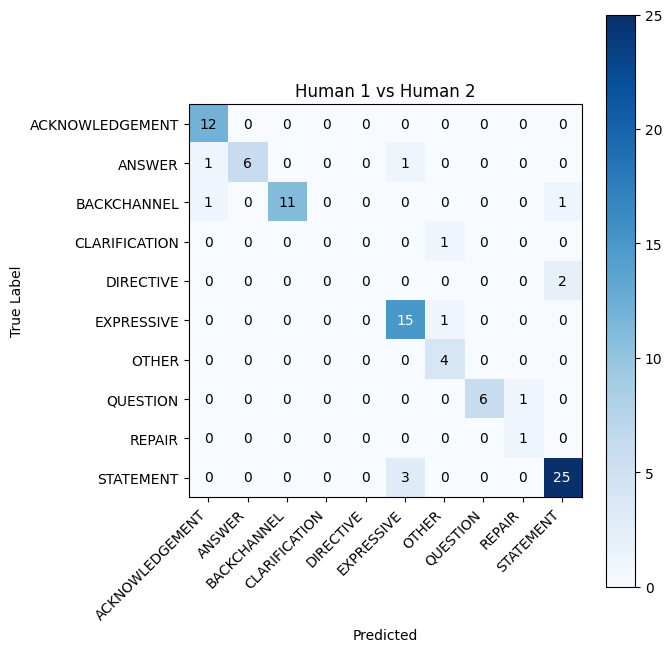

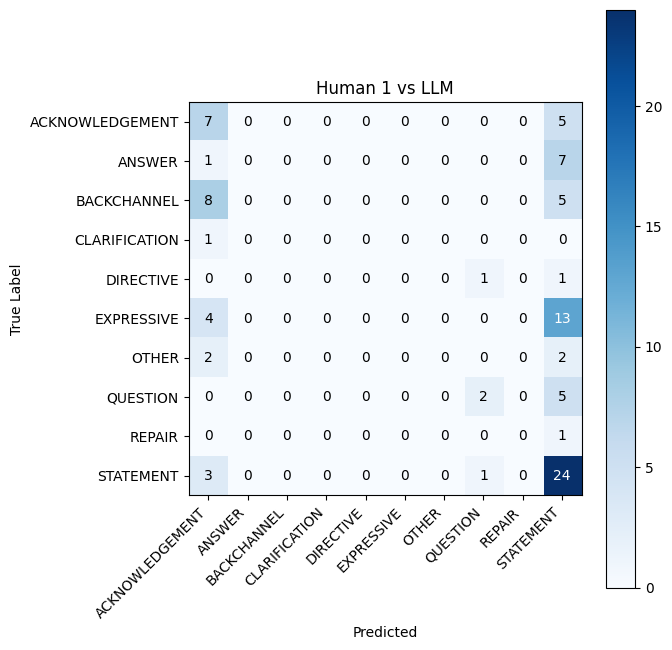

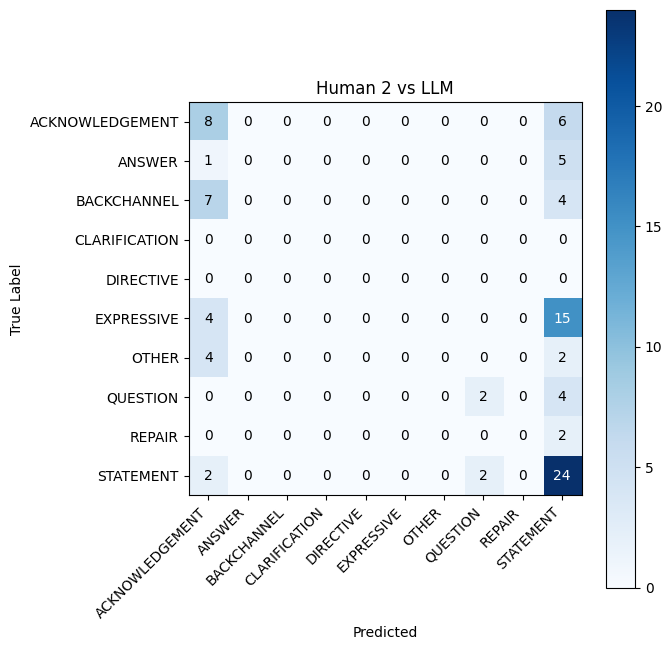

In [89]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

labels = sorted(eval_df["human1_label"].unique())  # adjust if needed

def plot_cm(true, pred, title):
    cm = confusion_matrix(true, pred, labels=labels)

    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, cmap="Blues")

    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_yticklabels(labels)

    ax.set_xlabel("Predicted")
    ax.set_ylabel("True Label")
    ax.set_title(title)

    for i in range(len(labels)):
        for j in range(len(labels)):
            ax.text(j, i, cm[i, j], ha="center", va="center",
                    color="white" if cm[i,j] > cm.max()/2 else "black")

    plt.colorbar(im)
    plt.tight_layout()
    plt.show()

plot_cm(h1, h2,  "Human 1 vs Human 2")
plot_cm(h1, llm, "Human 1 vs LLM")
plot_cm(h2, llm, "Human 2 vs LLM")
